In [1]:
import numpy as np
import json

pinn_run = "pfnn_10min"
spinn_run = "spinn_10min"

pinn_folder = f"./results_forward/{pinn_run}/"
spinn_folder = f"./results_forward/{spinn_run}/"


with open(pinn_folder + "config.json") as f:
    pinn_config = json.load(f)
with open(spinn_folder + "config.json") as f:
    spinn_config = json.load(f)

def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))


    return steps, values

losshistory_pinn = np.loadtxt(pinn_folder + "loss_history.dat")
losshistory_spinn = np.loadtxt(spinn_folder + "loss_history.dat")
pinn_loss = losshistory_pinn[:, -1]
pinn_steps_loaded = losshistory_pinn[:, 0]
spinn_loss = losshistory_spinn[:, -1]
spinn_steps_loaded = losshistory_spinn[:, 0]

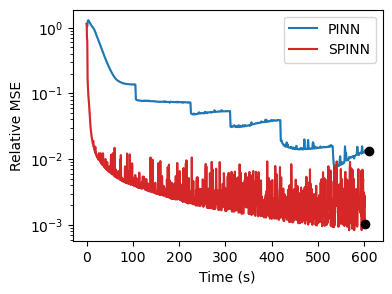

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

color_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[1], sns.color_palette()[4]]
sns.set_palette(color_palette)


step_type = ["iteration", "time"][1]
t_pinn = pinn_config["elapsed"]
t_spinn = spinn_config["elapsed"]

spinn_steps = np.array(spinn_steps_loaded) 
pinn_steps = np.array(pinn_steps_loaded) 
if step_type == "time":
    spinn_steps = spinn_steps * t_spinn/spinn_steps_loaded[-1]
    pinn_steps = pinn_steps * t_pinn/pinn_steps_loaded[-1]
    speed_factor = t_pinn/t_spinn*len(spinn_steps)/len(pinn_steps)

def init_losshistory(ax):
    ax.set_yscale('log')
    line_pinn, = ax.plot([], [], color=color_palette[0], zorder=3)
    line_spinn, = ax.plot([], [], color=color_palette[1], zorder=3)
    ax.plot(pinn_steps, pinn_loss, color=color_palette[0], alpha=0.2)
    ax.plot(spinn_steps, spinn_loss, color=color_palette[1], alpha=0.2)    
    scatter_pinn = ax.scatter([], [], c='k', zorder=4)
    scatter_spinn = ax.scatter([], [], c='k', zorder=4)
    ax.legend(["PINN", "SPINN"])
    ax.set_ylabel("Relative MSE")
    if step_type == "time":
        ax.set_xlabel("Time (s)")
    else:
        ax.set_xlabel("Iterations")
    return line_pinn, line_spinn, scatter_pinn, scatter_spinn

def update_losshistory(iterations, line_pinn, line_spinn, scatter_pinn, scatter_spinn):
    if step_type == "time" and iterations > 0:
        spinn_iter = int(iterations * speed_factor)
    else:
        spinn_iter = iterations

    line_pinn.set_data(pinn_steps[:iterations], pinn_loss[:iterations])
    scatter_pinn.set_offsets([pinn_steps[iterations], pinn_loss[iterations]])

    if spinn_iter < len(spinn_steps):
        line_spinn.set_data(spinn_steps[:spinn_iter], spinn_loss[:spinn_iter])
        scatter_spinn.set_offsets([spinn_steps[spinn_iter], spinn_loss[spinn_iter]])
    return line_pinn, line_spinn, scatter_pinn, scatter_spinn

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=100)
line_pinn, line_spinn, scatter_pinn, scatter_spinn = init_losshistory(ax)
update_losshistory(-1, line_pinn, line_spinn, scatter_pinn, scatter_spinn)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

In [3]:

logged_field = spinn_config["logged_fields"]
field_id = 0 #{0: "Ux", 1: "Uy", 2: "Sxx", 3: "Syy", 4: "Sxy"}
field_name = logged_field[str(field_id)]
_, V_spinn = read_data_file(spinn_folder + f"{field_name}_history.dat")
_, V_pinn = read_data_file(pinn_folder + f"{field_name}_history.dat")

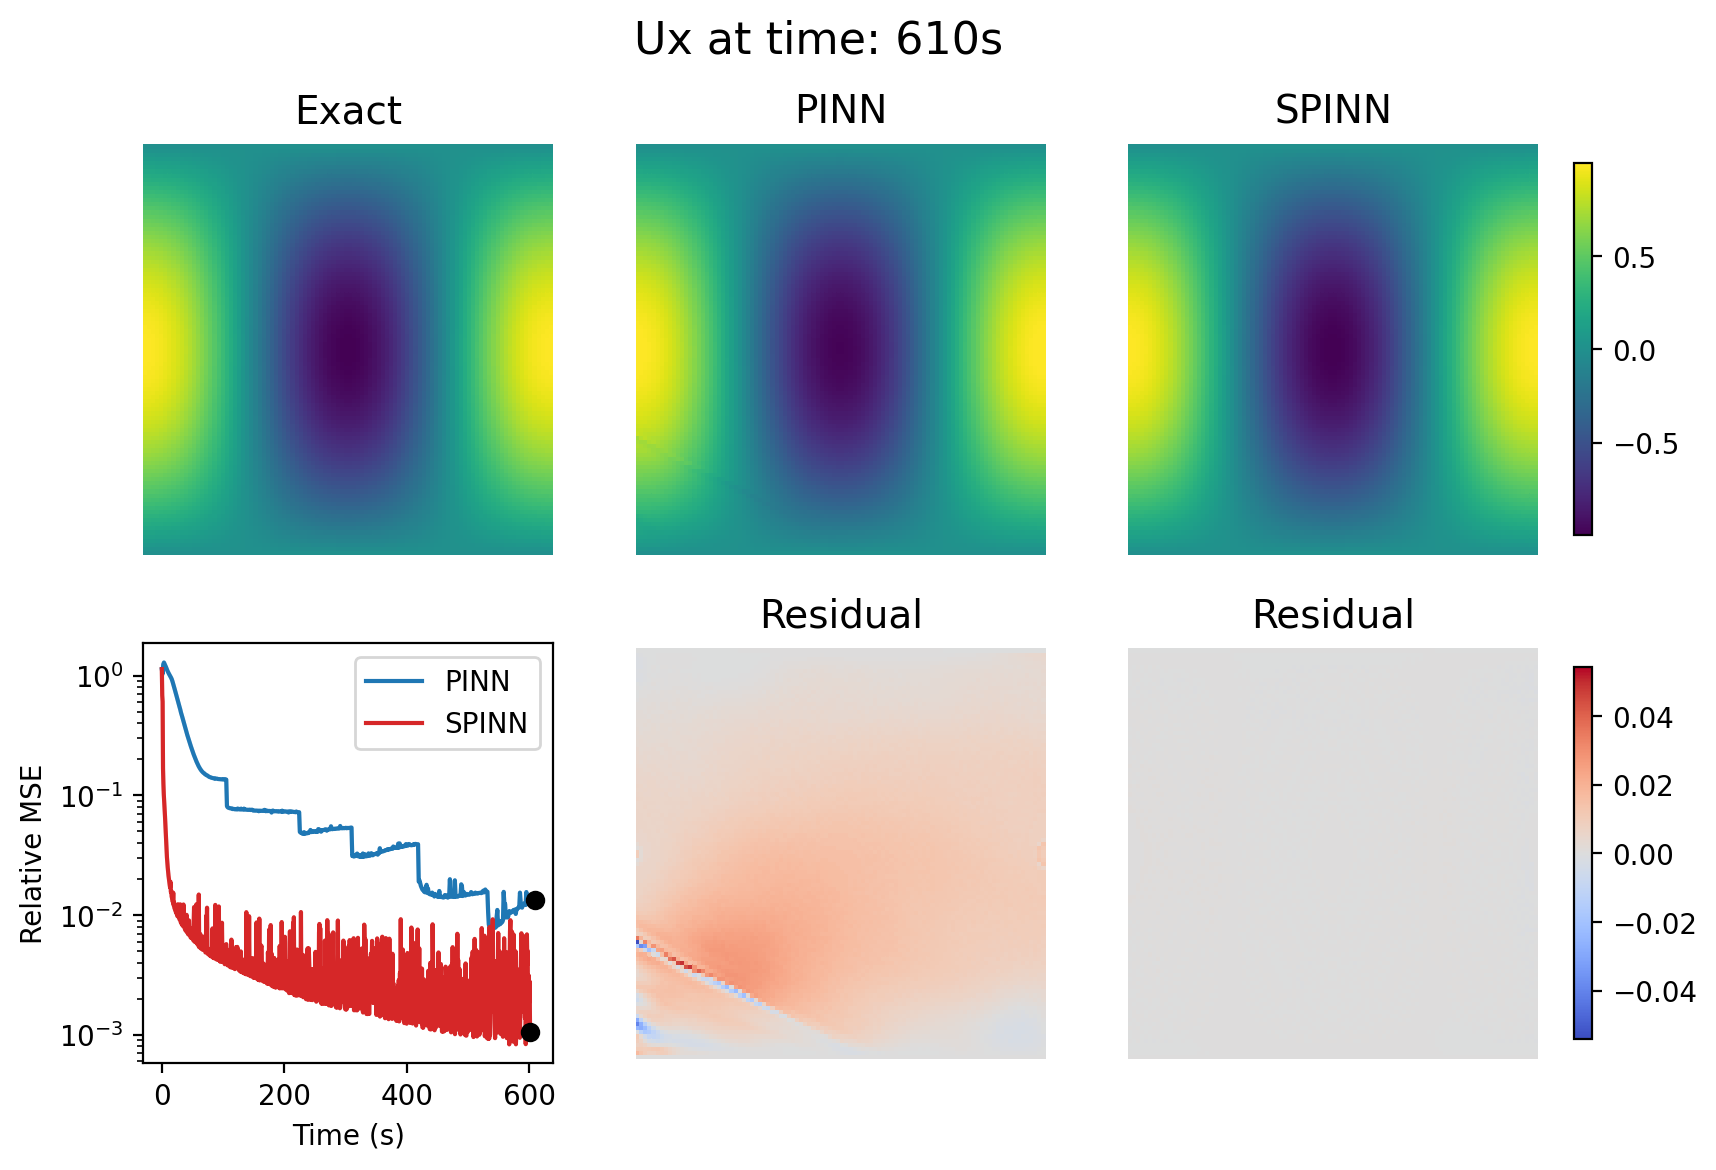

In [4]:
import matplotlib.colors as colors

Q = 4.0
def U_exact(X):
    x, y = X[:,0], X[:,1]
    #displacement U
    Ux = np.cos(2*np.pi*x) * np.sin(np.pi*y)
    Uy = np.sin(np.pi*x) * Q * y**4/4
    return np.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1)))

def pcolor_plot(AX, X, Y, C, title,colormap="viridis",norm=None):
    im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto',norm=norm)
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

i = -1
ngrid = 100

Xmesh, Ymesh = np.meshgrid(np.linspace(0, 1, ngrid), np.linspace(0, 1, ngrid), indexing='ij')
Xinput = np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1)))
Ux_exact = U_exact(Xinput)[:,field_id].reshape(Xmesh.shape)
Ux_norm = colors.Normalize(vmin=np.min(Ux_exact), vmax=np.max(Ux_exact))
diff = np.stack((np.array(V_pinn[i]).reshape(-1,ngrid,ngrid)-Ux_exact,np.array(V_spinn[i]).reshape(-1,ngrid,ngrid)-Ux_exact))
abs_diff = np.abs(diff)
cmax = abs_diff.max() if diff.max() > 0 else 0
cmin = -abs_diff.max() if diff.min() < 0 else 0
Udiff_norm = colors.Normalize(vmin=cmin, vmax=cmax)
  

fig, ax = plt.subplots(2,3,figsize = (9,6),dpi = 200)

Ux_norm = colors.Normalize(vmin=np.min(Ux_exact), vmax=np.max(Ux_exact))
Udiff_min = np.min([np.min(np.array(V_pinn[0]).reshape(-1,ngrid,ngrid)-Ux_exact),np.min(np.array(V_spinn[i]).reshape(-1,ngrid,ngrid)-Ux_exact)])
Udiff_max = np.max([np.max(np.array(V_pinn[0]).reshape(-1,ngrid,ngrid)-Ux_exact),np.max(np.array(V_spinn[i]).reshape(-1,ngrid,ngrid)-Ux_exact)])
normdiff = colors.Normalize(vmin=Udiff_min, vmax=Udiff_max)
  
im_00 = pcolor_plot(ax[0][0], Xmesh, Ymesh, Ux_exact, "Exact", norm=Ux_norm)
im_01 = pcolor_plot(ax[0][1], Xmesh, Ymesh, np.array(V_pinn[i]).reshape(ngrid,ngrid), "PINN", norm=Ux_norm)
im_02 = pcolor_plot(ax[0][2], Xmesh, Ymesh, np.array(V_spinn[i]).reshape(ngrid,ngrid), "SPINN", norm=Ux_norm)
cax = fig.add_axes([0.92, 0.55, 0.01, 0.31])
cbUx = fig.colorbar(im_00, ax=ax[0][2], cax=cax)
line_pinn, line_spinn, scatter_pinn, scatter_spinn = init_losshistory(ax[1][0])
line_pinn, line_spinn, scatter_pinn, scatter_spinn = update_losshistory(i, line_pinn, line_spinn, scatter_pinn, scatter_spinn)
im_11 = pcolor_plot(ax[1][1], Xmesh, Ymesh, np.array(V_pinn[i]).reshape(ngrid,ngrid)-Ux_exact, "Residual", colormap="coolwarm", norm=Udiff_norm)
im_12 = pcolor_plot(ax[1][2], Xmesh, Ymesh, np.array(V_spinn[i]).reshape(ngrid,ngrid)-Ux_exact, "Residual", colormap="coolwarm", norm=Udiff_norm)
cax = fig.add_axes([0.92, 0.13, 0.01, 0.31])
cbdiff = fig.colorbar(im_12, ax=ax[1][2], cax=cax)

fig.suptitle(f"{field_name} at {step_type}: {pinn_steps[i]:.0f}{"s" if step_type == "time" else ""}", fontsize=16)
plt.show()
    

In [42]:
import matplotlib.animation as animation
from IPython.display import HTML
from itertools import chain

def animate(i, im_01, im_02, im_11, im_12, line_pinn, line_spinn, scatter_pinn, scatter_spinn, normdiff, cbdiff):

    if step_type == "time" and i > 0:
        spinn_iter = int(i * speed_factor)
    else:
        spinn_iter = i

    fig.suptitle(f"{field_name} at {step_type}: {pinn_steps[i]:.0f}{"s" if step_type == "time" else ""}", fontsize=16)

    im_01.set_array(np.array(V_pinn[i]).reshape(ngrid,ngrid).ravel())
    im_11.set_array((np.array(V_pinn[i]).reshape(ngrid,ngrid)-Ux_exact).ravel())
    if spinn_iter < len(spinn_steps):
        im_02.set_array(np.array(V_spinn[spinn_iter]).reshape(ngrid,ngrid).ravel())
        im_12.set_array((np.array(V_spinn[spinn_iter]).reshape(ngrid,ngrid)-Ux_exact).ravel())

    line_pinn, line_spinn, scatter_pinn, scatter_spinn = update_losshistory(i, line_pinn, line_spinn, scatter_pinn, scatter_spinn)
    
    diff = np.stack((np.array(V_pinn[i]).reshape(-1,ngrid,ngrid)-Ux_exact,np.array(V_spinn[min(spinn_iter,len(spinn_steps)-1)]).reshape(-1,ngrid,ngrid)-Ux_exact))
    abs_diff = np.abs(diff)
    cmax = abs_diff.max() if diff.max() > 0 else 0
    cmin = -abs_diff.max() if diff.min() < 0 else 0

    normdiff.vmin = cmin
    normdiff.vmax = cmax

    im_11.set_norm(normdiff)
    im_12.set_norm(normdiff)
    cbdiff.update_normal(im_12)

    return im_01, im_02, im_11, im_12, line_pinn, line_spinn, scatter_pinn, scatter_spinn, normdiff, cbdiff

def subsample_steps(steps, sub_factors):
    section_ends = [int(len(steps)*i/len(sub_factors)) for i in range(1, len(sub_factors)+1)]
    frame_steps_lists = []
    for i, step_size in enumerate(sub_factors):
        start = section_ends[i-1] if i > 0 else 0
        end = section_ends[i]
        frame_steps_lists.append(range(start, end, step_size))
    frame_steps = chain.from_iterable(frame_steps_lists)
    return frame_steps


steps = list(range(len(pinn_steps)))
sub_factors = list(range(10,40,4)) + [40]*20 #slower at the beginning
frame_steps = list(subsample_steps(steps, sub_factors))


anim = animation.FuncAnimation(fig, animate, fargs=(im_01, im_02, im_11, im_12, line_pinn, line_spinn, scatter_pinn, scatter_spinn, normdiff, cbdiff), frames=frame_steps, interval=100, repeat=False)
fps = 10
print("Video duration: ", len(frame_steps)/fps, "s")
# HTML(anim.to_jshtml())

Video duration:  17.9 s


/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [43]:
# anim.save('PINN_vs_SPINN_Ux.gif', writer='imagemagick', fps=5)
video_name = f"./results_forward/videos/{field_name}_{step_type}_{pinn_run}_vs_{spinn_run}.mp4"
anim.save(video_name, writer='ffmpeg', fps=10)